# [Introduction to Data Science](http://datascience-intro.github.io/1MS041-2024/)    
## 1MS041, 2024 
&copy;2024 Raazesh Sainudiin, Benny Avelin. [Attribution 4.0 International     (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)

# Training and Testing

## Topics

* Supervised Learning
* Probabilistic viewpoint of machine learning
* Logistic regression
* Measuring model performance
* Multiple class logistic regression

## The underlying problem

Consider the supervised learning problem. I.e. we have

1. A generator G
2. A supervisor S
3. A learning machine LM

The generator, gives $X$ from $F_X$ and the supervisor $S$ gives $Y$ from $F_{Y \mid X}$, the goal of the learning machine is to mimic the supervisor in some way.

We will look at this from the context of the Pattern Recognition problem i.e. $Y$ is binary.

What we have seen so far is that we start with the statistical model, i.e. that

$$
    \mathcal{F} = \{F(x,y) = H(y;p(x))F(x), p \in C([0,1],R)\}
$$

where $H(y;p)$ is the CDF of Bernoulli($p$).

Our model space is $\mathcal{M} = \{g_\lambda(x): g_\lambda(x) \in \{0,1\}\}$.

Let us consider that we have some loss function $L$ and consider the risk

$$
   R(\lambda) = \int L(y, g_\lambda(x)) dF(x,y) = \mathbb{E}[L(Y,g_\lambda(X)]
$$

As we have alluded to before, the learning machine LM does not have access to $F(x,y)$ directly, but only though observations (examples) that the supervisor S provides, and thus the only thing the LM can hope to do, is to approximate the risk using those observations. The natural candidate which we have seen before in chapter 6, is that we will use the empirical risk

$$
    \hat R_n(\lambda) = \frac{1}{n} \sum_{i=1}^n L(Y_i, g_\lambda(X_i))
$$

Recall this data that we used as an example for the perceptron

<img src="./images/blue_red_points.png"></a>

In this case, the perceptron algorithm produced a decision function $g_{\hat \lambda}$ that perfectly split the data into two parts, i.e.

$$
    \hat R_n(\hat \lambda) = 0
$$

> The main goal of learning is the one of generalization, i.e. that the decision function we found actually performs well on unseen data.

That is, we want the true risk to also be small, specifically we want

$$
    R(\hat \lambda) \text{ is small.}
$$

Again, this would involve computing an expecation and the LM does not have access to $F(x,y)$, and thus would need to compute the empirical counterpart. **But we have used up all our data!!**

> What can we do?

If we where smart we would have kept some data that we did not use to find $\hat \lambda$ and use that data to approximate $R(\hat \lambda)$. This is called the **train**-**test** methodology. Lets see how that would work

In [10]:
import numpy as np

def gen_data(n_points=5,sep=1):
    np.random.seed(3)
    W = np.array([[1,-1],[1,1]])/np.sqrt(2)
    rnd_pos_1 = np.random.uniform(0,1,size=(n_points,2))
    X1 = (rnd_pos_1 + np.array([-1-sep,0]))@W
    rnd_pos_2 = np.random.uniform(0,1,size=(n_points,2))
    X2 = (rnd_pos_2 + np.array([+sep,0]))@W
    
    Xall = np.concatenate([X1,X2],axis=0)
    y1 = np.ones(shape=n_points)
    y2 = np.zeros(shape=n_points)
    yall = np.concatenate([y1,y2])
    
    indices = np.arange(len(Xall))
    np.random.shuffle(indices)
    return Xall[indices,:],yall[indices]

X, Y = gen_data(n_points=100,sep=-0.3)

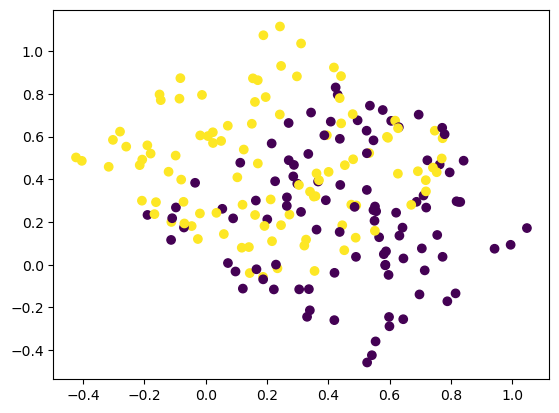

In [11]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=Y)

Now that we have generated our data $T_{n+m}:=\{(X_1,Y_1)$, $\ldots$, $(X_{n+m},Y_{n+m})\}$ which are sampled i.i.d., let us denote $Tr_n = \{(X_1,Y_1)$, $\ldots$, $(X_{n},Y_{n})\}$ the **training data** and $Te_m = \{(X_{n+1},Y_{n+1})$, $\ldots$, $(X_{n+m},Y_{n+m})\}$ the **testing data**.

In [12]:
n_plus_m = len(X)
n = n_plus_m//2
m = n_plus_m-n
X_train = X[0:n,:]
Y_train = Y[0:n]
X_test = X[n:n+m,:]
Y_test = Y[n:n+m]

On the training data $Tr_n$ we will train the LM using some method (in this case the support vector machine from last time)

In [14]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf')

svc.fit(X_train,Y_train)

SVC()

This will find $g_{\hat \lambda}$, and store it inside the object `svc`.
To compute the empirical training risk for the $0-1$ loss 

$$
    \hat R_n(Tr_n; g_{\hat \lambda})
$$

we can do as follows, first let us compute $g_{\hat \lambda}(X_i)$ for $(X_i,Y_i) \in Tr_n$, we call this `prediction`

In [15]:
prediction = svc.predict(X_train)

In [16]:
prediction

array([1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.])

The empirical risk over the training data is just the average number of times the prediction deviates from the truth

In [17]:
np.mean(Y_train!=prediction)

0.26

We now want to use our testing data to evaluate the performance, i.e. to estimate $R(\hat \lambda)$. This is simply done similarly

In [18]:
test_prediction = svc.predict(X_test)

In [19]:
test_prediction

array([1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
test_risk = np.mean(Y_test!=test_prediction)
test_risk

0.36

From this we can see that clearly the empirical risk over the training set is much smaller than the empirical risk over the testing data. This is simply because we used the training data to fit our model, it is thus always smaller than the true risk. When using the new dataset to test our model we are formally working "conditioned" on the training data and thus the empirical test risk is just a sum of i.i.d. random variables, each taking value either 0 or 1. Hoeffdings inequality thus tells us that the test risk is close to the true risk.

So, lets do that, i.e. let us build an interval of confidence around the true risk. Lemma 3.8 tells us that since the random variable $L(Y,g_{\hat \lambda}(X)) \sim $Bernoulli($R(\hat \lambda)$), we can choose our level of confidence, say $\alpha = 0.01$ and then compute $\delta = \frac{1}{\sqrt{m}}\sqrt{\frac{1}{2}\ln\left ( \frac{2}{\alpha} \right )}$

In [21]:
alpha = 0.1
delta = (1/np.sqrt(m))*np.sqrt((1/2)*np.log(2/alpha))
print("Confidence interval around the true risk is [%.2f,%.2f]" % (test_risk-delta,test_risk+delta))

Confidence interval around the true risk is [0.24,0.48]


## Other metrics

Sometimes it is important to compute other metrics than the $0-1$ loss. Actually this is $1-$accuracy (the term used in machine learning community).

The other classical quantities to look at is the so called **precision** and **recall**. Their definitions are as follows

$$
    \begin{aligned}
        \text{Precision:} \quad P(Y = 1 \mid g(X) = 1) \\
        \text{Recall:} \quad P(g(X) = 1 \mid Y = 1).
    \end{aligned}
$$

Lets start with Precision, it reads "What is the probability of $Y=1$ given that our decision function predicts $1$". Lets compute that for our trained model

In [ ]:
# As we have mentioned before, conditional probabilities are easiest to compute by filtering
Y_test_g_1 = Y_test[test_prediction == 1]

# The variable above then contains all the true labels given that our model predicts 1
print(Y_test_g_1)
print(len(Y_test_g_1))

To estimate the probability of $Y=1$ we can just take the mean of the above

In [ ]:
precision = np.mean(Y_test_g_1)
precision

So when the model predicts $1$, there is a $56\%$ of the true label being $1$. That is why its called precision!!

We can compute the interval of confidence for this one as well using Lemma 3.8

In [ ]:
alpha = 0.01
delta = (1/np.sqrt(len(Y_test_g_1)))*np.sqrt((1/2)*np.log(2/alpha))
print("Confidence interval around precision [%.2f,%.2f]" % (precision-delta,precision+delta))

The recall on the other hand reads "What is the probability of the model guessing $1$ given that the true label is $1$". (You should think about why its termed recall).

This we again do using filtering, but this time on $Y=1$:

In [ ]:
# As we have mentioned before, conditional probabilities are easiest to compute by filtering
test_prediction_Y_1 = test_prediction[Y_test == 1]

# The variable above then contains all the true labels given that our model predicts 1
print(test_prediction_Y_1)
print(len(test_prediction_Y_1))

In [ ]:
recall = np.mean(test_prediction_Y_1)
recall

As we can see, the recall is high. So when the true label is $1$, the model is very likely to predict correcly. Again we can derive an interval of confidence using Lemma 3.8

In [ ]:
alpha = 0.01
delta = (1/np.sqrt(len(test_prediction_Y_1)))*np.sqrt((1/2)*np.log(2/alpha))
print("Confidence interval around precision [%.2f,%.2f]" % (recall-delta,recall+delta))

Of course the upper bound can be replaced by $1$.

> In the above we computed several intervals, and we should really use the union bound correction of the interval lenght that was derived in the Remark after Lemma 3.8. This is also known as **Bonferroni correction**.

### Using sklearn to compute the metrics

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,test_prediction))

Above you can see that the `classification_report` of sklearn actually outputs some different averaged metrics, and you can see that there is a precision and recall for class $0$ as well. These are simply 

$$
    \begin{aligned}
        \text{Precision:} \quad P(Y = 0 \mid g(X) = 0) \\
        \text{Recall:} \quad P(g(X) = 0 \mid Y = 0).
    \end{aligned}
$$

### Implementing our own classification report with confidence

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def precision_recall(y_true,
    y_pred,
    labels=None,alpha=0.01, correction=1):
    p = []
    r = []
    f1 = []
    support = []
    for label in labels:
        y_true_pred_label = y_true[y_pred == label]
        precision = np.mean(y_true_pred_label == label)
        delta = (1/np.sqrt(len(y_true_pred_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        p.append("%.2f : [%.2f,%.2f]" % (precision, np.maximum(precision-delta,0),np.minimum(precision+delta,1)))
        
        y_pred_true_label = y_pred[y_true == label]
        recall = np.mean(y_pred_true_label == label)
        delta = (1/np.sqrt(len(y_pred_true_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        r.append("%.2f : [%.2f,%.2f]" % (recall, np.maximum(recall-delta,0),np.minimum(recall+delta,1)))
        
    return (p,r)

def accuracy_interval(y_true,y_pred,alpha=0.01,correction=1):
    acc = np.mean(y_true == y_pred)
    delta = (1/np.sqrt(len(y_true)))*np.sqrt((1/2)*np.log(2*correction/alpha))
    return "%.2f : [%.2f,%.2f]" % (acc, np.maximum(acc-delta,0),np.minimum(acc+delta,1))

def classification_report_interval(
    y_true,
    y_pred,
    labels=None,
    alpha = 0.01,
    union_bound_correction=True
):
    digits = 18
    target_names = None
    if labels is None:
        labels = list(set(y_true).union(set(y_pred)))
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall"]
    # compute per-class results without averaging
    # Simple correction using the union bound
    # We are computing 2 intervals for each label for precision and recall
    # In addition we are computing 2 intervals for accuracy
    # This is in total 2*n_labels+2
    if (union_bound_correction):
        correction = 2*len(labels)+2
    else:
        correction=1
    p, r = precision_recall(
        y_true,
        y_pred,
        labels=labels,
        alpha=alpha,
        correction=correction
    )

    rows = zip(target_names, p, r)

    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, digits)
    head_fmt = "{:>{width}s} " + " {:>{digits}}" * len(headers)
    report = head_fmt.format("labels", *headers, width=width,digits=digits)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>{digits}s}" * 2 + "\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    row_fmt_acc = "{:>{width}s} " + " {:>{digits}s}" * 2 + " {:>{digits}s}""\n"
    report += "\n"
    accuracy = accuracy_interval(y_true,y_pred,alpha=alpha,correction=correction)
    report+=row_fmt_acc.format(*("accuracy","","",accuracy),width=width,digits=digits)

    return report

In [ ]:
print(classification_report_interval(Y_test,test_prediction,alpha=0.01,union_bound_correction=True))

In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

from sklearn.svm import SVC

labels = digits['target']

X = digits['data']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,labels)

per = SVC(kernel='linear')

per.fit(X_train,Y_train)

In [ ]:
print(classification_report_interval(Y_test,per.predict(X_test),union_bound_correction=True))

In [ ]:
print(classification_report_interval(Y_test,per.predict(X_test),union_bound_correction=False))

## Overfitting



In [ ]:
# Lets create a dataset with only noise
X = np.random.normal(size=(1000,2))
Y = np.random.randint(0,2,size=1000)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

In [ ]:
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

In [ ]:
DecisionTreeClassifier()

Lets take a look at how the decision function looks like, we can do this by predicting on a bunch of random points.

In [ ]:
X_plot = np.random.normal(size=(2000,2))
prediction = dtc.predict(X_plot)
plt.scatter(X_plot[:,0],X_plot[:,1],c=prediction,alpha=0.5)

This means that it learned from noise and have learned completely irrelevant decisions. Lets check what the performance is on the data training data

In [ ]:
print(classification_report(Y_train,dtc.predict(X_train)))

So it correctly predicts all points, lets check the test metrics

In [ ]:
print(classification_report_interval(Y_test,dtc.predict(X_test)))

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,Y_train)

In [ ]:
print(classification_report(Y_train,lr.predict(X_train)))
print(classification_report_interval(Y_test,lr.predict(X_test)))

In [ ]:
LogisticRegression()

These are quite different, we are now around 0.5. Which is what we expect, since the label was a coin flip with equal probability.

> Overfitting is thus the concept that we have fit "too well" to the training data and we have inflated our confidence.

Why is this happening?

## Overfitting and a posteriori vs a priori error

There are essentially two ways to make guarantees with machine learning, one is

* a priori (before the fact)
* a posteriori (after the fact).

What we saw above is the so called a posteriori version of guarantee. I.e. we are training and after the training (after the fact) we will test, to get the error. This is very applicable to many situations, as it does not guarantee anything about performance. If its bad, we are guaranteed that it is bad when testing, and if it is good, we are guaranteed it is good.

The other side of the coin is the a priori (before the fact) guarantee. These kinds of guarantees often come in the form of

> Given that we know how many data points we will get, can we say how good our learned model will be with respect to the best possible model in our class?

Remark: A consequence of this is also that the training and test error will be close, and they will both be close to the best possible.

> Given a model class $\mathcal{M}$ the a priori generalization statement can be written mathematicall as
$$
    P \left ( R(\hat{\phi}) > \inf_{\phi \in \mathcal{M}} R(\phi) + \epsilon \right ) \text{ is small.}
$$
Where $\hat \phi$ is the empirical risk minimizer.

In the below example we have few samples that we are trying to fit with a polynomial. It plots all estimated functions with the set degree in the `PolynomialFeatures` object. Change this from 1,2,3,4 and see how the **bias** and **variance** changes of the estimated functions.

(-2.0, 2.0)

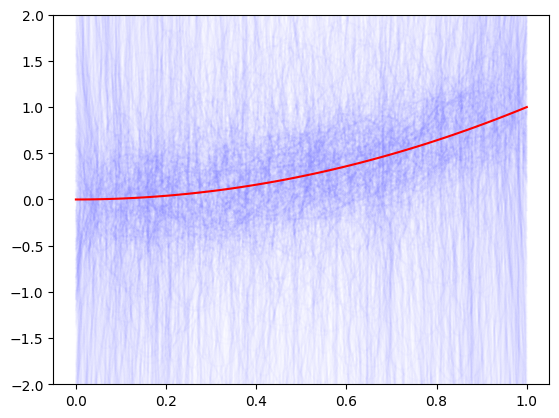

In [ ]:
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
import numpy as np

Poly = pre.PolynomialFeatures(degree=1)

for i in range(1000):
    n_samples = 6
    X = np.random.uniform(size=(n_samples,1))
    Y = X.reshape(-1)**2+np.random.uniform(size=(n_samples))-1/2
    X_poly = Poly.fit_transform(X)

    lr = LinearRegression()

    lr.fit(X_poly,Y)
    X_plot = np.linspace(0,1,100).reshape(-1,1)
    X_plot_poly = Poly.fit_transform(X_plot)
    Y_plot = lr.predict(X_plot_poly)
    
    #plt.scatter(X,Y)
    plt.plot(X_plot,Y_plot,alpha=0.01,color='blue')

plt.plot(X_plot,X_plot**2,color='red')
plt.ylim(-2,2)


### What reduces overfitting?

As we saw, overfitting learns random noise. Since random noise is very complicated (its random, it has little structure) the resulting model must thus be very complicated. **Look at the decision tree above**. But this is not the entire truth, actually it is like this

> "Overfitting" -> too complicated model

However, it is not the other way around. It is also a lot more complicated to explain all the things that goes into making a good model and what highly complicated models to not overfit in some circumstances and overfit in others.

However, there is a theory that allows us to make guarantees in certain restricted cases and it looks like this
$$
    P \left ( R(\hat{\phi}) > \inf_{\phi \in \mathcal{M}} R(\phi) + \epsilon \right ) \leq 8 \left ( \frac{n e}{k}\right )^k e^{-n\epsilon^2/64}.
$$
and $k$ here is a measure of complexity of the model space $\mathcal{M}$, termed the VC-dimension. We have the immediate conclusion

> Smaller VC-dimension -> better guarantee

### What is the VC-dimension of different models?

This is a very hard problem, even the concept VC dimension is itself conceptually difficult. What we can say though is that, the **Support Vector Machine with linear kernel** and **Logistic regression** both have VC-dimension equal to the dimension of the space $-1$.